## Import libraries:

In [1]:
from imports import *

## 1. Preprocessing

The data corresponds to the Monte Carlo simulation of the SBND experiment. It was obtained by simulating the creation of neutrinos in the beam and their subsequent interaction in SBND, as well as the simulation of the detector's response to the particles resulting from the interaction of the neutrinos.

### Load variables

In [2]:
file_path = '/data/vidales/opana_tree_combined_v0411_both.root'
file = uproot.open(file_path)
optree = file['opanatree']['OpAnaTree'] # Tree con número de fotoelectrones
print("Keys in optree:", optree.keys())

Keys in optree: ['eventID', 'runID', 'subrunID', 'nuvX', 'nuvY', 'nuvZ', 'nuvT', 'nuvE', 'stepX', 'stepY', 'stepZ', 'stepT', 'dE', 'energydep', 'energydepX', 'energydepY', 'energydepZ', 'E', 'StartPx', 'StartPy', 'StartPz', 'EndPx', 'EndPy', 'EndPz', 'process', 'trackID', 'motherID', 'PDGcode', 'InTimeCosmics', 'InTimeCosmicsTime', 'dEtpc', 'dEpromx', 'dEpromy', 'dEpromz', 'dEspreadx', 'dEspready', 'dEspreadz', 'dElowedges', 'dEmaxedges', 'nopflash', 'flash_id', 'flash_time', 'flash_total_pe', 'flash_pe_v', 'flash_tpc', 'flash_y', 'flash_yerr', 'flash_z', 'flash_zerr', 'flash_x', 'flash_xerr', 'flash_ophit_time', 'flash_ophit_risetime', 'flash_ophit_starttime', 'flash_ophit_amp', 'flash_ophit_area', 'flash_ophit_width', 'flash_ophit_pe', 'flash_ophit_ch']


In [3]:
# Load variables to be predicted and associated data in a single step
nuvX, nuvZ, nuvT, f_ophit_PE, f_ophit_ch, f_ophit_t, flash_tpc, flash_time, dEpromx, dEpromy, dEpromz, dEtpc = (optree[key].array() for key in ['nuvX','nuvZ', 'nuvT', 'flash_ophit_pe', 'flash_ophit_ch', 'flash_ophit_time', 'flash_tpc', 'flash_time','dEpromx', 'dEpromy', 'dEpromz','dEtpc'])

### Filter events with more than one neutrino! Very important!

In [6]:
# Assuming all variables are awkward arrays
nuvX_1 = nuvX[ak.num(nuvT) == 1]
nuvZ_1 = nuvZ[ak.num(nuvT) == 1]
nuvT_1 = nuvT[ak.num(nuvT) == 1]
f_ophit_PE_1 = f_ophit_PE[ak.num(nuvT) == 1]
f_ophit_ch_1 = f_ophit_ch[ak.num(nuvT) == 1]
f_ophit_t_1 = f_ophit_t[ak.num(nuvT) == 1]
flash_tpc_1 = flash_tpc[ak.num(nuvT) == 1]
flash_time_1 = flash_time[ak.num(nuvT) == 1]
dEpromx_1 = dEpromx[ak.num(nuvT) == 1]
dEpromy_1 = dEpromy[ak.num(nuvT) == 1]
dEpromz_1 = dEpromz[ak.num(nuvT) == 1]
dEtpc_1 = dEtpc[ak.num(nuvT) == 1]
# Now all the variables are filtered and contain only subarrays with length 1 in nuvT.

In [64]:
print("nuvT_1:", nuvT_1)
print("flash_time_1", flash_time_1)
print("f_ophit_t_1", f_ophit_t_1)

nuvT_1: [[1.83e+03], [1.85e+03], [520], [1.02e+03], ..., [889], [1.35e+03], [642]]
flash_time_1 [[1.83, 1.89], [1.85, 1.9], ..., [1.35, ...], [0.942, 0.644, 0.924, 0.684]]
f_ophit_t_1 [[[9.86, 9.84, 9.83, 9.79, 9.78, ..., 1.99, 1.99, 1.99, 1.98, 1.99], ...], ...]


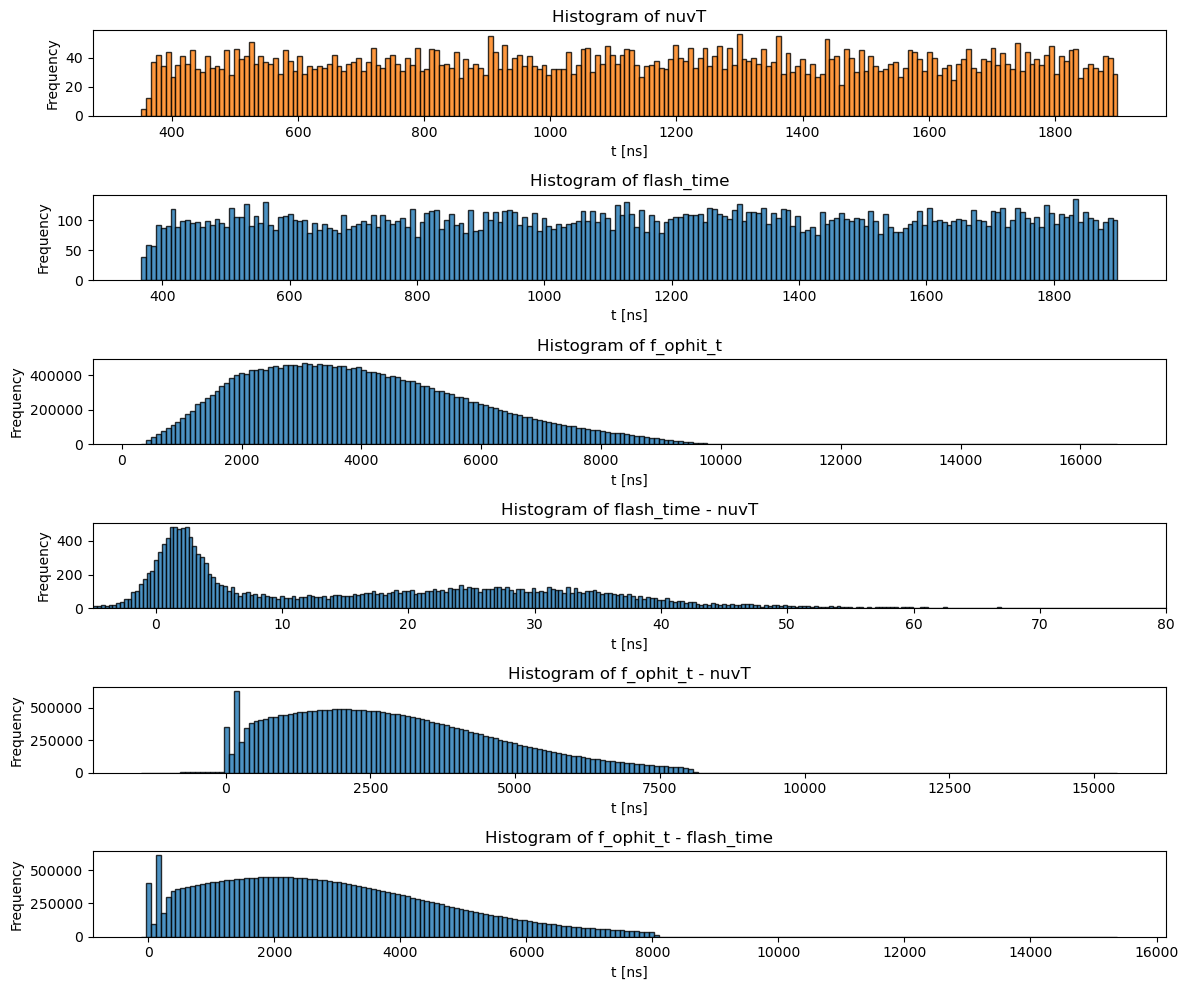

In [8]:
import matplotlib.pyplot as plt

nuvT_np = ak.flatten(nuvT_1)
flash_time_np = ak.flatten(1e3*flash_time_1)
f_ophit_t_np = ak.flatten(1e3*f_ophit_t_1, axis=None)
rest1_np = ak.flatten(1e3*flash_time_1 - nuvT_np, axis=None)
rest2_np = ak.flatten(1e3*f_ophit_t_1 - nuvT_np, axis=None)
rest3_np = ak.flatten(1e3*f_ophit_t_1 - 1e3*flash_time_1, axis=None)

fig, axs = plt.subplots(6, 1, figsize=(12, 10))  # Two subplots side by side

# Plot nuvT histogram
axs[0].hist(nuvT_np, bins=200, color='#ff7f0e', edgecolor='black', alpha=0.8)
axs[0].set_xlabel("t [ns]")
axs[0].set_ylabel("Frequency")
axs[0].set_title("Histogram of nuvT")

# Plot flash_time histogram
axs[1].hist(flash_time_np, bins=200, color='#1f77b4', edgecolor='black', alpha=0.8)
axs[1].set_xlabel("t [ns]")
axs[1].set_ylabel("Frequency")
axs[1].set_title("Histogram of flash_time")

# Plot flash_time histogram
axs[2].hist(f_ophit_t_np, bins=200, color='#1f77b4', edgecolor='black', alpha=0.8)
axs[2].set_xlabel("t [ns]")
axs[2].set_ylabel("Frequency")
axs[2].set_title("Histogram of f_ophit_t")

# Plot flash_time histogram
axs[3].hist(rest1_np, bins=10000, color='#1f77b4', edgecolor='black', alpha=0.8)
axs[3].set_xlabel("t [ns]")
axs[3].set_ylabel("Frequency")
axs[3].set_title("Histogram of flash_time - nuvT")
axs[3].set_xlim(-5,80)

# Plot flash_time histogram
axs[4].hist(rest2_np, bins=200, color='#1f77b4', edgecolor='black', alpha=0.8)
axs[4].set_xlabel("t [ns]")
axs[4].set_ylabel("Frequency")
axs[4].set_title("Histogram of f_ophit_t - nuvT")

# Plot flash_time histogram
axs[5].hist(rest3_np, bins=200, color='#1f77b4', edgecolor='black', alpha=0.8)
axs[5].set_xlabel("t [ns]")
axs[5].set_ylabel("Frequency")
axs[5].set_title("Histogram of f_ophit_t - flash_time")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [6]:
# Get the total length of the nuvX array
total_length = ak.sum(ak.num(nuvT_1))
print("Total number of elements in nuvT:", total_length)

Total number of elements in nuvT: 29582


### Filter events with no flash

In [7]:
nuvX_2 = nuvX_1[ak.num(flash_time_1) != 0]
nuvZ_2 = nuvZ_1[ak.num(flash_time_1) != 0]
nuvT_2 = nuvT_1[ak.num(flash_time_1) != 0]
f_ophit_PE_2 = f_ophit_PE_1[ak.num(flash_time_1) != 0]
f_ophit_ch_2 = f_ophit_ch_1[ak.num(flash_time_1) != 0]
f_ophit_t_2 = f_ophit_t_1[ak.num(flash_time_1) != 0]
flash_tpc_2 = flash_tpc_1[ak.num(flash_time_1) != 0]
flash_time_2 = flash_time_1[ak.num(flash_time_1) != 0]
dEpromx_2 = dEpromx_1[ak.num(flash_time_1) != 0]
dEpromy_2 = dEpromy_1[ak.num(flash_time_1) != 0]
dEpromz_2 = dEpromz_1[ak.num(flash_time_1) != 0]
dEtpc_2 = dEtpc_1[ak.num(flash_time_1) != 0]

In [19]:
print(nuvT_2[523])
print((flash_time*1000)[523])
print((f_ophit_t*1000)[523])

[1.47e+03]
[1.86e+03, 1.3e+03, 1.33e+03]
[[7.89e+03, 5.99e+03, 5.72e+03, ..., 1.93e+03, 1.92e+03, 1.92e+03], ..., [...]]


In [6]:
# Get the total length of the nuvX array
total_length = ak.sum(ak.num(nuvT_2))
print("Total number of elements in dEpromx:", total_length)

Total number of elements in dEpromx: 28986


### Corrección PTM delay

**Correction PMT delay 135 ns due to the difference between the photon arrival times (at the photocathode)
and the digitised signal (at the anode)**

In [6]:
PDSMap = file['opanatree']['PDSMapTree']
ID = PDSMap['OpDetID'].array()
Type = PDSMap['OpDetType'].array()
channel_dict = {id_val: (int(type_val)) for id_val, type_val in zip(ID[0],Type[0])}
print(channel_dict)

{0: 3, 1: 3, 2: 3, 3: 3, 4: 3, 5: 3, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 2, 19: 2, 20: 2, 21: 2, 22: 2, 23: 2, 24: 3, 25: 3, 26: 3, 27: 3, 28: 3, 29: 3, 30: 3, 31: 3, 32: 3, 33: 3, 34: 3, 35: 3, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 2, 43: 2, 44: 2, 45: 2, 46: 2, 47: 2, 48: 2, 49: 2, 50: 2, 51: 2, 52: 2, 53: 2, 54: 3, 55: 3, 56: 3, 57: 3, 58: 3, 59: 3, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 2, 73: 2, 74: 2, 75: 2, 76: 2, 77: 2, 78: 3, 79: 3, 80: 3, 81: 3, 82: 3, 83: 3, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 2, 97: 2, 98: 2, 99: 2, 100: 2, 101: 2, 102: 3, 103: 3, 104: 3, 105: 3, 106: 3, 107: 3, 108: 3, 109: 3, 110: 3, 111: 3, 112: 3, 113: 3, 114: 1, 115: 1, 116: 1, 117: 1, 118: 1, 119: 1, 120: 2, 121: 2, 122: 2, 123: 2, 124: 2, 125: 2, 126: 2, 127: 2, 128: 2, 129: 2, 130: 2, 131: 2, 132: 3, 133: 3, 134: 3, 135: 3, 136: 3, 137: 3, 138: 

In [7]:
# Convertimos el diccionario en un conjunto para los valores 0 y 1
channels_to_correct = [ch for ch, value in channel_dict.items() if value in {0, 1}]
print(channels_to_correct)
print(len(channels_to_correct))

[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 36, 37, 38, 39, 40, 41, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 114, 115, 116, 117, 118, 119, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 192, 193, 194, 195, 196, 197, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 270, 271, 272, 273, 274, 275, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305]
120


**It took six minutes in total**

In [8]:
# Crear una máscara que indique si cada elemento de f_ophit_ch está en channel_list
mask = ak.Array([
    [[ch in channels_to_correct for ch in ophit] for ophit in flash] for flash in f_ophit_ch_2
])

In [9]:
# Aplicar la máscara para ajustar f_ophit_t
f_ophit_t_adj = ak.where(mask, f_ophit_t_2 - 0.135, f_ophit_t_2)

### New method -- TPC selection

In [10]:
pmt_channels = [ch for ch, value in channel_dict.items() if value in {0, 1}]
xas_channels = [ch for ch, value in channel_dict.items() if value in {2, 3}]

# Function to separate odd and even numbers
def separate_odd_even(numbers):
    even_numbers = [num for num in numbers if num % 2 == 0]
    odd_numbers = [num for num in numbers if num % 2 != 0]
    return even_numbers, odd_numbers


pmt_even, pmt_odd = separate_odd_even(pmt_channels)
xas_even, xas_odd = separate_odd_even(xas_channels)

In [11]:
print("pmt_even:", pmt_even)
print("pmt_odd:", pmt_odd)
print("xas_even:", xas_even)
print("xas_odd:", xas_odd)
print(f_ophit_ch_2[0][1])

pmt_even: [6, 8, 10, 12, 14, 16, 36, 38, 40, 60, 62, 64, 66, 68, 70, 84, 86, 88, 90, 92, 94, 114, 116, 118, 138, 140, 142, 144, 146, 148, 162, 164, 166, 168, 170, 172, 192, 194, 196, 216, 218, 220, 222, 224, 226, 240, 242, 244, 246, 248, 250, 270, 272, 274, 294, 296, 298, 300, 302, 304]
pmt_odd: [7, 9, 11, 13, 15, 17, 37, 39, 41, 61, 63, 65, 67, 69, 71, 85, 87, 89, 91, 93, 95, 115, 117, 119, 139, 141, 143, 145, 147, 149, 163, 165, 167, 169, 171, 173, 193, 195, 197, 217, 219, 221, 223, 225, 227, 241, 243, 245, 247, 249, 251, 271, 273, 275, 295, 297, 299, 301, 303, 305]
xas_even: [0, 2, 4, 18, 20, 22, 24, 26, 28, 30, 32, 34, 42, 44, 46, 48, 50, 52, 54, 56, 58, 72, 74, 76, 78, 80, 82, 96, 98, 100, 102, 104, 106, 108, 110, 112, 120, 122, 124, 126, 128, 130, 132, 134, 136, 150, 152, 154, 156, 158, 160, 174, 176, 178, 180, 182, 184, 186, 188, 190, 198, 200, 202, 204, 206, 208, 210, 212, 214, 228, 230, 232, 234, 236, 238, 252, 254, 256, 258, 260, 262, 264, 266, 268, 276, 278, 280, 282, 284, 2

In [12]:
def categorize_first_number(vector):
    if isinstance(vector, (list, ak.Array)) and len(vector) > 0:
        first_number = vector[0]
        if first_number in pmt_even:
            return 0
        elif first_number in pmt_odd:
            return 1
        elif first_number in xas_even:
            return 2
        elif first_number in xas_odd:
            return 3
    return -1  # If not found in any list or if vector is empty

categorized_flashes = ak.Array([[categorize_first_number(flash) for flash in event] for event in f_ophit_ch_2])
print(categorized_flashes)

[[0, 2], [0, 2], [0, 2], [0, 1, 3], ..., [0, ...], [1, 3], [0, 2], [0, 1, 2, 3]]


**categorized_flashes is the same as flash_tpc**

In [27]:
# 1. Sumar los PEs de cada flash (suma sobre la dimensión ophit)
sum_pe = ak.sum(f_ophit_PE_2, axis=2)  # Resultado: [evento][flash]

# 2. Crear máscaras para las categorías:
# Grupo Even: categorías 0 y 2
# Grupo Odd: categorías 1 y 3
mask_even = (categorized_flashes == 0) | (categorized_flashes == 2)
mask_odd  = (categorized_flashes == 1) | (categorized_flashes == 3)

# 3. Sumar, por evento, los PEs para cada grupo
sum_even = ak.sum(ak.where(mask_even, sum_pe, 0), axis=1)
sum_odd  = ak.sum(ak.where(mask_odd, sum_pe, 0), axis=1)

# 4. Para cada evento, si hay 2 o menos flashes se conservan todos.
#    Si hay más, se selecciona el grupo (even u odd) que sume mayor PE.
n_flashes = ak.num(categorized_flashes)
decision = sum_even >= sum_odd  # Array booleano por evento

# Generar, para cada evento, la máscara de selección de flashes:
selected_mask = ak.Array([
    np.ones(n, dtype=bool) if n <= 2 
    else (mask_even[i] if decision[i] else mask_odd[i])
    for i, n in enumerate(ak.to_list(n_flashes))
])

# 5. Función para filtrar un array de eventos usando la máscara, sin usar ak.compress
def filter_by_mask(array, mask):
    """
    Filtra cada evento (lista de flashes) en 'array' utilizando la máscara booleana 'mask'.
    """
    return ak.Array([
        [item for item, flag in zip(event, event_mask) if flag]
        for event, event_mask in zip(ak.to_list(array), ak.to_list(mask))
    ])

# Filtrar cada variable según la máscara de selección:
f_ophit_t_adj_sel       = filter_by_mask(f_ophit_t_adj, selected_mask)
f_ophit_PE_2_sel        = filter_by_mask(f_ophit_PE_2, selected_mask)
f_ophit_ch_2_sel        = filter_by_mask(f_ophit_ch_2, selected_mask)
categorized_flashes_sel = filter_by_mask(categorized_flashes, selected_mask)
flash_time_sel          = filter_by_mask(flash_time_2, selected_mask)

# Mostrar resultados:
print('f_ophit_t_adj_sel:', f_ophit_t_adj_sel)
print('f_ophit_PE_2_sel:', f_ophit_PE_2_sel)
print('f_ophit_ch_2_sel:', f_ophit_ch_2_sel)
print('categorized_flashes_sel:', categorized_flashes_sel)
print('flash_time_sel:', flash_time_sel)

f_ophit_t_adj_sel: [[[8.68, 8.67, 8.62, 8.6, 8.58, ..., 0.751, 0.769, 0.755, 0.757], ...], ...]
f_ophit_PE_2_sel: [[[0.866, 0.903, 1.17, 2.87, 1.08, ..., 2.11, 7.08, 2.41, 7.05], ...], ...]
f_ophit_ch_2_sel: [[[165, 89, 89, 223, 167, 85, 173, ..., 85, 67, 15, 241, 95, 91, 17], ...], ...]
categorized_flashes_sel: [[1, 3], [0, 2], [0, 2], [1, 3], [1, ...], ..., [1, 3], [0, 2], [0, 2], [1, 3]]
flash_time_sel: [[0.842, 0.827], [0.792, 0.814], [1.28, ...], ..., [1.05, 1.07], [0.458, 0.474]]


**Para coger los flashes out of TPC**

In [14]:
# 1. Sumar los PEs de cada flash (suma sobre la dimensión ophit)
sum_pe = ak.sum(f_ophit_PE_2, axis=2)  # Resultado: [evento][flash]

# 2. Crear máscaras para las categorías:
# Grupo Even: categorías 0 y 2
# Grupo Odd: categorías 1 y 3
mask_even = (categorized_flashes == 0) | (categorized_flashes == 2)
mask_odd  = (categorized_flashes == 1) | (categorized_flashes == 3)

# 3. Sumar, por evento, los PEs para cada grupo
sum_even = ak.sum(ak.where(mask_even, sum_pe, 0), axis=1)
sum_odd  = ak.sum(ak.where(mask_odd, sum_pe, 0), axis=1)

# 4. Para cada evento, si hay 2 o menos flashes NO SE TOMA NINGUNO.
#    Si hay más, se selecciona el grupo opuesto al que tenga mayor PE.
n_flashes = ak.num(categorized_flashes)
decision = sum_even < sum_odd  # Ahora tomamos el grupo opuesto al que tiene más PE

# Generar, para cada evento, la máscara de selección de flashes:
selected_mask = ak.Array([
    np.zeros(n, dtype=bool) if n <= 2  # Si hay 2 o menos flashes, se descartan todos
    else (mask_even[i] if decision[i] else mask_odd[i])  # Tomamos el grupo opuesto
    for i, n in enumerate(ak.to_list(n_flashes))
])

# 5. Función para filtrar un array de eventos usando la máscara, sin usar ak.compress
def filter_by_mask(array, mask):
    """
    Filtra cada evento (lista de flashes) en 'array' utilizando la máscara booleana 'mask'.
    """
    return ak.Array([
        [item for item, flag in zip(event, event_mask) if flag]
        for event, event_mask in zip(ak.to_list(array), ak.to_list(mask))
    ])

# Filtrar cada variable según la máscara de selección:
f_ophit_t_adj_sel2       = filter_by_mask(f_ophit_t_adj, selected_mask)
f_ophit_PE_2_sel2        = filter_by_mask(f_ophit_PE_2, selected_mask)
f_ophit_ch_2_sel2        = filter_by_mask(f_ophit_ch_2, selected_mask)
categorized_flashes_sel2 = filter_by_mask(categorized_flashes, selected_mask)
flash_time_sel2          = filter_by_mask(flash_time_2, selected_mask)

# Mostrar resultados:
print('f_ophit_t_adj_sel2:', f_ophit_t_adj_sel2)
print('f_ophit_PE_2_sel2:', f_ophit_PE_2_sel2)
print('f_ophit_ch_2_sel2:', f_ophit_ch_2_sel2)
print('categorized_flashes_sel2:', categorized_flashes_sel2)
print('flash_time_sel2:', flash_time_sel2)

f_ophit_t_adj_sel2: [[], ..., [[8.8, 8.74, 8.7, 8.62, 8.55, ..., 0.937, 0.937, 0.939, 0.949], ...]]
f_ophit_PE_2_sel2: [[], [], ..., [[0.92, 1.82, 2.27, 1.38, 0.826, ..., 135, 161, 69.6, 86.6], ...]]
f_ophit_ch_2_sel2: [[], [], ..., [[90, 166, 216, 92, 302, 142, ..., 302, 250, 248, 226, 224], ...]]
categorized_flashes_sel2: [[], [], [], [0], [], [], [0, 2], ..., [0, ...], [1, 3], [], [], [], [], [0, 2]]
flash_time_sel2: [[], [], [], [1.03], [], [], ..., [1.39, ...], [], [], [], [], [0.942, 0.924]]


**Usando flash_tpc -> los flashes con nº 0 (PMTs y pares (x<0)), los flashes con nº 1 (PMTs e impares (x>0)), los flashes con nº 2 (XAs y pares (x<0)), los flashes con nº 3 (XAs e impares (x>0))**

### Eliminate useless values and interactions with deposition less than 200 MeV

In [10]:
# Select first element if nuvX is negative, second element if nuvX is positive
dEpromx_2 = ak.where(nuvX_2 < 0, dEpromx_2[:, 0], dEpromx_2[:, 1])
dEpromy_2 = ak.where(nuvX_2 < 0, dEpromy_2[:, 0], dEpromy_2[:, 1])
dEpromz_2 = ak.where(nuvX_2 < 0, dEpromz_2[:, 0], dEpromz_2[:, 1])
dEtpc_2 = ak.where(nuvX_2 <0, dEtpc_2[:, 0], dEtpc_2[:, 1])
# Print the result
print("Selected elements:", dEpromx_2)
print("Length:", len(dEpromx_2))

Selected elements: [[-142], [-128], [-110], [89.8], [182], ..., [-201], [123], [-2.29], [37]]
Length: 28986


**cambiar por versiones filtered si quiero no meter todas las capas**

In [11]:
# Create a boolean mask where dEpromx_f_unique is not -999
# Also select events with deposition >200 MeV (dEtpc_f > 200)

mask = (dEpromx_2 != -999) & (dEpromy_2 != -999) & (dEpromz_2 != -999) & (dEtpc_2 > 200)
#mask = (dEpromx != -999) & (dEpromy != -999) & (dEpromz != -999)
mask_1d = ak.to_numpy(ak.flatten(mask))

# Apply the mask to both the image and dEpromx_f_unique to keep only the valid entries

nuvX_3 = nuvX_2[mask_1d]
nuvZ_3 = nuvZ_2[mask_1d]
nuvT_3 = nuvT_2[mask_1d]
f_ophit_PE_3 = f_ophit_PE_2[mask_1d]
f_ophit_ch_3 = f_ophit_ch_2[mask_1d]
f_ophit_t_3 = f_ophit_t_adj[mask_1d]
flash_time_3 = flash_time_2[mask_1d]
dEpromx_3 = dEpromx_2[mask_1d]
dEpromy_3 = dEpromy_2[mask_1d]
dEpromz_3 = dEpromz_2[mask_1d]
dEtpc_3 = dEtpc_2[mask_1d]
#categorized_flashes_3 = categorized_flashes[mask_1d]

**por si acaso volver a filtrar para no dejar flashes vacíos**

In [12]:
nuvX_4 = nuvX_3[ak.num(flash_time_3) != 0]
nuvZ_4 = nuvZ_3[ak.num(flash_time_3) != 0]
nuvT_4 = nuvT_3[ak.num(flash_time_3) != 0]
f_ophit_PE_4 = f_ophit_PE_3[ak.num(flash_time_3) != 0]
f_ophit_ch_4 = f_ophit_ch_3[ak.num(flash_time_3) != 0]
f_ophit_t_4 = f_ophit_t_3[ak.num(flash_time_3) != 0]
flash_time_4 = flash_time_3[ak.num(flash_time_3) != 0]
dEpromx_4 = dEpromx_3[ak.num(flash_time_3) != 0]
dEpromy_4 = dEpromy_3[ak.num(flash_time_3) != 0]
dEpromz_4 = dEpromz_3[ak.num(flash_time_3) != 0]
dEtpc_4 = dEtpc_3[ak.num(flash_time_3) != 0]
#categorized_flashes_4 = categorized_flashes_3[ak.num(flash_time_3) != 0]

In [20]:
print(f_ophit_t_4[1])
print(flash_time_4[3])
print(nuvT_4[3])

[[9.76, 9.74, 9.75, 9.72, 9.72, 9.71, ..., 1.87, 1.88, 1.88, 1.84, 1.78], ...]
[1.63, 1.66]
[1.62e+03]


### Guardar y cargar datos

In [ ]:
# Diccionario con los arrays
data = {
    "nuvX_4": nuvX_4,
    "nuvZ_4": nuvZ_4,
    "nuvT_4": nuvT_4,
    "f_ophit_PE_4": f_ophit_PE_4,
    "f_ophit_ch_4": f_ophit_ch_4,
    "f_ophit_t_4": f_ophit_t_4,
    "flash_time_4": flash_time_4,
    "dEpromx_4": dEpromx_4,
    "dEpromy_4": dEpromy_4,
    "dEpromz_4": dEpromz_4,
    "dEtpc_4": dEtpc_4,
}

# Convertir a Arrow Table y guardar como Parquet
table = ak.to_arrow_table(data)
pq.write_table(table, "v1203_noTPCselection.parquet")

In [ ]:
import awkward as ak
import pyarrow.parquet as pq

# Cargar archivo Parquet
table = pq.read_table("v1202_noTPCselection.parquet")

# Convertir de Arrow Table a awkward Array
data_loaded = {name: ak.from_arrow(column) for name, column in zip(table.column_names, table.columns)}

# Acceder a las variables cargadas
nuvX_4= data_loaded["nuvX_4"]
nuvZ_4 = data_loaded["nuvZ_4"]
nuvT_4 = data_loaded["nuvT_4"]
f_ophit_PE_4 = data_loaded["f_ophit_PE_4"]
f_ophit_ch_4 = data_loaded["f_ophit_ch_4"]
f_ophit_t_4 = data_loaded["f_ophit_t_4"]
flash_time_4 = data_loaded["flash_time_4"]
dEpromx_4 = data_loaded["dEpromx_4"]
dEpromy_4 = data_loaded["dEpromy_4"]
dEpromz_4 = data_loaded["dEpromz_4"]
dEtpc_4 = data_loaded["dEtpc_4"]


# Verificar estructura
print(ak.type(nuvX_4))

### corte en 10 ophits

In [13]:
# Obtener los índices ordenados de manera creciente dentro de cada flash
sorted_indices = ak.argsort(f_ophit_t_4, axis=-1, ascending=True)
# Ordenar los datos de los ophits dentro de cada flash
f_ophit_t_sorted = f_ophit_t_4[sorted_indices]  # Ordenar f_ophit_t
f_ophit_PE_sorted = f_ophit_PE_4[sorted_indices]  # Reordenar PE
f_ophit_ch_sorted = f_ophit_ch_4[sorted_indices]  # Reordenar canales

In [14]:
def select_top_ophits_per_channel(f_ophit_t_sorted, f_ophit_PE_sorted, f_ophit_ch_sorted, max_hits=10, num_channels=312):
    selected_t, selected_PE, selected_ch = [], [], []
    
    for event_idx in range(len(f_ophit_ch_sorted)):
        selected_event_t, selected_event_PE, selected_event_ch = [], [], []
        
        for flash_idx in range(len(f_ophit_ch_sorted[event_idx])):
            flash_ch = f_ophit_ch_sorted[event_idx][flash_idx]
            flash_t = f_ophit_t_sorted[event_idx][flash_idx]
            flash_PE = f_ophit_PE_sorted[event_idx][flash_idx]
            
            # Crear un array de contadores para cada canal
            channel_counts = np.zeros(num_channels, dtype=int)
            mask = np.zeros(len(flash_ch), dtype=bool)  # Máscara para seleccionar los valores permitidos
            
            for i, ch in enumerate(flash_ch):
                if channel_counts[ch] < max_hits:
                    mask[i] = True  # Mantener este ophit
                    channel_counts[ch] += 1  # Incrementar el contador para este canal
            
            # Aplicar la máscara para seleccionar los valores
            selected_event_t.append(flash_t[mask])
            selected_event_PE.append(flash_PE[mask])
            selected_event_ch.append(flash_ch[mask])
        
        selected_t.append(selected_event_t)
        selected_PE.append(selected_event_PE)
        selected_ch.append(selected_event_ch)
    
    return ak.Array(selected_t), ak.Array(selected_PE), ak.Array(selected_ch)

In [15]:
selected_ophits_t, selected_ophits_PE, selected_ophits_ch= select_top_ophits_per_channel(f_ophit_t_sorted, f_ophit_PE_sorted, f_ophit_ch_sorted, max_hits=10)

### Correccion temporal

**To have good time variables we need two corrections. 1- ToF from beamline origin to upstream wall of detector (110m) ~ 367 ns is the minimum that happens in the case parent hadron decays just after the beryllium target. 2- Take module 19 because we care about the relative position with respect to the max of the bunches not the absolute time in the detector window ~ 1.8us**

In [16]:
ToF_inside = ak.flatten(nuvZ_4) / 3E10 *1E9
ToF_outside = 110 / 3E8 * 1E9
bunch_separation = 19
print("ToF_inside:",ToF_inside, "ns")
print(f"ToF_outside {ToF_outside:.0f} ns")
print(f"bunch_separation: {bunch_separation:.0f} ns")

ToF_inside: [3.61, 4.69, 6.06, 4.48, 9.19, -0.134, ..., 2.25, 5.88, 0.267, 6.22, 8.32, 7.4] ns
ToF_outside 367 ns
bunch_separation: 19 ns


**si no quiero corrección no correr siguiente celda**

In [17]:
#ToF outside solo añade un shift global. ToF inside no se le mete a hit_t porque debe intentar predecirlo. Hit_t no sé si tiene sentido hacer el módulo 19 pero creo que no.
#hit_nuvT_c= np.mod(hit_nuvT - ToF_outside - ToF_inside, bunch_separation)
nuvT_c= nuvT_4 - ToF_inside - ToF_outside
nuvT_c_bunch = np.mod(nuvT_c + 7, bunch_separation) # +7 is to center the distribution (not doing anymore)

In [19]:
selected_ophits_t_c_1 = selected_ophits_t*1000 - ToF_inside - ToF_outside
selected_ophits_t_c_2 = selected_ophits_t*1000 - ToF_inside - ToF_outside - ak.flatten(nuvT_c)

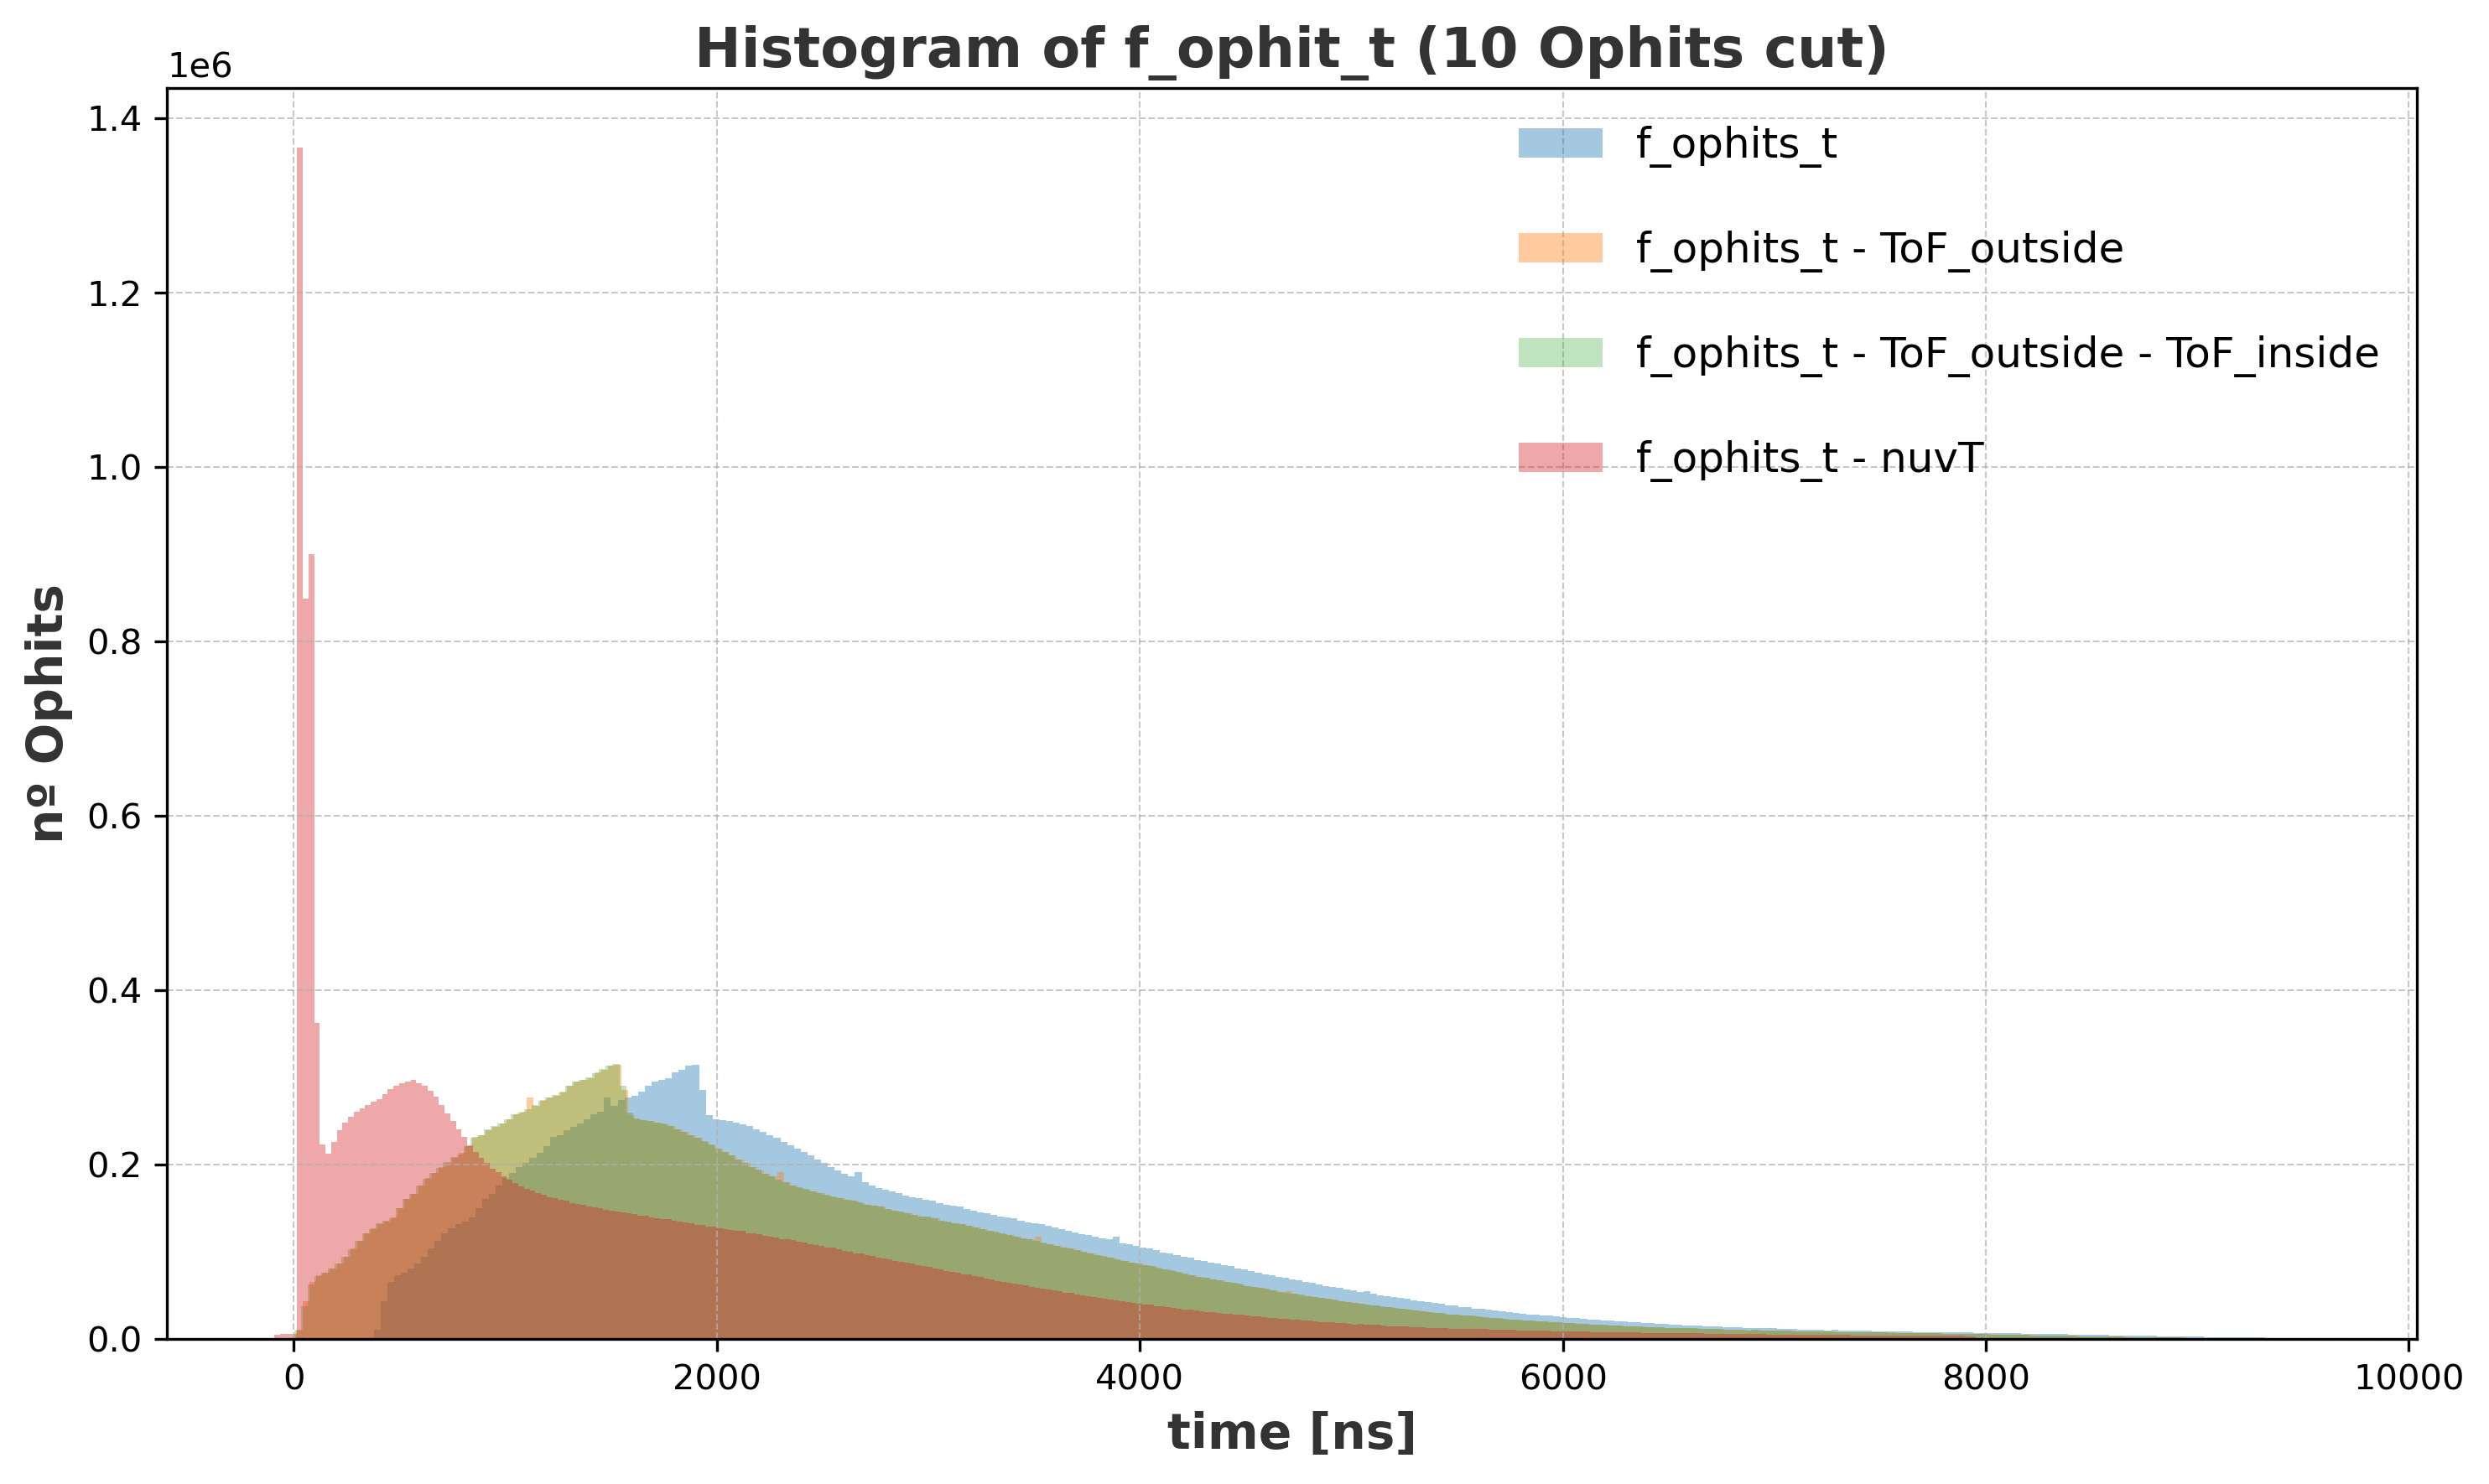

In [83]:
import matplotlib.pyplot as plt
import numpy as np


# Crear el histograma
plt.figure(figsize=(10, 6), dpi=300)  # Aumentamos la calidad de la imagen con dpi=300

# Histograma para cada variable con diferentes colores y alpha

plt.hist(ak.flatten(selected_ophits_t*1000, axis=None), bins=300, alpha=0.4, label='f_ophits_t', color='#1f77b4')  # Azul
plt.hist(ak.flatten(f_ophit_t_c_1, axis=None), bins=300, alpha=0.4, label='f_ophits_t - ToF_outside', color='#ff7f0e')        # Naranja
plt.hist(ak.flatten(f_ophit_t_c_2, axis=None), bins=300, alpha=0.3, label='f_ophits_t - ToF_outside - ToF_inside', color='#2ca02c')        # Verde
plt.hist(ak.flatten(f_ophit_t_c_3, axis=None), bins=400, alpha=0.4, label='f_ophits_t - nuvT', color='#d62728')        # Rojo

# Personalización del gráfico para mejorar la estética
plt.xlabel('time [ns]', fontsize=14, weight='bold', color='#333333')
plt.ylabel('nº Ophits', fontsize=14, weight='bold', color='#333333')
plt.title('Histogram of f_ophit_t (10 Ophits cut)', fontsize=16, weight='bold', color='#333333')
plt.legend(loc='upper right', fontsize=12, frameon=False, labelspacing=1.5)
plt.xlim(-600, 10040)  # Limitar el eje x para mejorar la visualización
# Agregar una cuadrícula para mejor visualización
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Asegurarse de que el espacio se use adecuadamente
plt.tight_layout()

# Mostrar el gráfico
plt.show()


The BNB is created by extracting protons from the Booster accelerator at Fermilab and impacting them on a beryllium target. The time structure of the delivered proton beam consists of a series of 81 bunches, each about 1.3 ns wide and 19 ns apart, defining a spill length of 1.6 µs

In [20]:
# Diccionario con los arrays
data = {
    "nuvT": nuvT_4,
    "nuvT_c": nuvT_c,
    "nuvT_c_bunch": nuvT_c_bunch,
    "dEpromx": dEpromx_4,
    "dEpromy": dEpromy_4,
    "dEpromz": dEpromz_4
}

# Convertir a Arrow Table y guardar como Parquet
table = ak.to_arrow_table(data)
pq.write_table(table, "saved_archives/v1303_noTPCselection_c1&c2.parquet")

## 2. PE and time matrix (now)

In [26]:
n_events = len(f_ophit_ch_4)

# Create matrices to store the number of photoelectrons and times for each event and channel
pe_matrix = np.zeros((n_events, 312))

# Populate the matrices
for i in range(n_events):
    for j in range(len(f_ophit_ch_4[i])):
        for k, l in zip(f_ophit_PE_4[i][j], f_ophit_ch_4[i][j]):
            pe_matrix[i][l] += k

In [27]:
# Save the matrices to a CSV file
np.savetxt("saved_archives/pe_matrix_&_time_matrix/v1303_noTPC_pe_matrix.csv", pe_matrix, delimiter=",")

In [24]:
n_events = len(selected_ophits_t_c_1)

# Create matrices to store the number of photoelectrons and times for each event and channel
pe_matrix = np.zeros((n_events, 312))
time_matrix = np.zeros((n_events, 312))

# Populate the matrices
for i in range(n_events):
    for j in range(len(selected_ophits_t_c_1[i])):
        for k, l, t in zip(selected_ophits_PE[i][j], selected_ophits_ch[i][j], selected_ophits_t_c_1[i][j]):
            pe_matrix[i][l] += k
            time_matrix[i][l] += k * t  # Weight times by charge

                # Normalize time_matrix using the sum of weights

for i in range(n_events):
    for j in range(312):
        if pe_matrix[i][j] != 0:
            time_matrix[i][j] /= pe_matrix[i][j]
        else:
            time_matrix[i][j] = 0

In [25]:
# Save the matrices to a CSV file
np.savetxt("saved_archives/pe_matrix_&_time_matrix/v1303_noTPC_10ophit_time_matrix.csv", time_matrix, delimiter=",")

In [22]:
# Obtener los índices ordenados de manera creciente dentro de cada flash
sorted_indices = ak.argsort(f_ophit_t_c_1, axis=-1, ascending=True)
# Ordenar los datos de los ophits dentro de cada flash
f_ophit_t_sorted = f_ophit_t_c_1[sorted_indices]  # Ordenar f_ophit_t
f_ophit_PE_sorted = f_ophit_PE_4[sorted_indices]  # Reordenar PE
f_ophit_ch_sorted = f_ophit_ch_4[sorted_indices]  # Reordenar canales

In [23]:
print("f_ophit_t_sorted:", f_ophit_t_sorted)
print("f_ophit_PE_sorted:", f_ophit_PE_sorted)
print("f_ophit_ch_sorted:", f_ophit_ch_sorted)

f_ophit_t_sorted: [[[1.48e+03, 1.48e+03, 1.48e+03, ..., 9.32e+03, 9.33e+03, 9.35e+03], ...], ...]
f_ophit_PE_sorted: [[[4.42e+03, 3.2e+03, 3.54e+03, 3.72e+03, ..., 0.941, 1.28, 0.608], ...], ...]
f_ophit_ch_sorted: [[[70, 16, 14, 68, 94, 92, 12, ..., 16, 298, 70, 68, 66, 148, 90], ...], ...]


**Método de corte por número de ophits en canal (tarda 8 min. y medio)**

In [24]:
def select_top_ophits_per_channel(f_ophit_t_sorted, f_ophit_PE_sorted, f_ophit_ch_sorted, max_hits=10, num_channels=312):
    selected_t, selected_PE, selected_ch = [], [], []
    
    for event_idx in range(len(f_ophit_ch_sorted)):
        selected_event_t, selected_event_PE, selected_event_ch = [], [], []
        
        for flash_idx in range(len(f_ophit_ch_sorted[event_idx])):
            flash_ch = f_ophit_ch_sorted[event_idx][flash_idx]
            flash_t = f_ophit_t_sorted[event_idx][flash_idx]
            flash_PE = f_ophit_PE_sorted[event_idx][flash_idx]
            
            # Crear un array de contadores para cada canal
            channel_counts = np.zeros(num_channels, dtype=int)
            mask = np.zeros(len(flash_ch), dtype=bool)  # Máscara para seleccionar los valores permitidos
            
            for i, ch in enumerate(flash_ch):
                if channel_counts[ch] < max_hits:
                    mask[i] = True  # Mantener este ophit
                    channel_counts[ch] += 1  # Incrementar el contador para este canal
            
            # Aplicar la máscara para seleccionar los valores
            selected_event_t.append(flash_t[mask])
            selected_event_PE.append(flash_PE[mask])
            selected_event_ch.append(flash_ch[mask])
        
        selected_t.append(selected_event_t)
        selected_PE.append(selected_event_PE)
        selected_ch.append(selected_event_ch)
    
    return ak.Array(selected_t), ak.Array(selected_PE), ak.Array(selected_ch)

In [25]:
selected_ophits_t, selected_ophits_PE, selected_ophits_ch= select_top_ophits_per_channel(f_ophit_t_sorted, f_ophit_PE_sorted, f_ophit_ch_sorted, max_hits=10)

In [26]:
selected_ophits_t_c2 = selected_ophits_t - ak.flatten(nuvT_c)

**Método de corte por tiempo desde primer ophit en cada canal (tarda 3 min)**

In [21]:
import numpy as np
import awkward as ak

def select_early_ophits_per_channel(f_ophit_t_sorted, f_ophit_PE_sorted, f_ophit_ch_sorted, time_window=30):
    selected_t = []
    selected_PE = []
    selected_ch = []

    for event_idx in range(len(f_ophit_ch_sorted)):
        event_t, event_PE, event_ch = [], [], []
        
        for flash_idx in range(len(f_ophit_ch_sorted[event_idx])):
            # Extraer los datos del destello como arrays NumPy
            flash_t = np.asarray(f_ophit_t_sorted[event_idx][flash_idx])
            flash_PE = np.asarray(f_ophit_PE_sorted[event_idx][flash_idx])
            flash_ch = np.asarray(f_ophit_ch_sorted[event_idx][flash_idx])
            
            # Obtener el índice del primer hit por canal
            unique_channels, first_indices = np.unique(flash_ch, return_index=True)
            first_hit_times = flash_t[first_indices]  # Tiempo del primer hit por canal
            
            # Crear un diccionario o array para mapear canal -> primer tiempo
            channel_to_first_time = dict(zip(unique_channels, first_hit_times))
            
            # Vectorizar la comparación: tiempo de cada hit vs. primer tiempo de su canal
            first_times_per_hit = np.array([channel_to_first_time[ch] for ch in flash_ch])
            mask = flash_t <= first_times_per_hit + time_window
            
            # Aplicar la máscara para seleccionar los hits
            event_t.append(flash_t[mask])
            event_PE.append(flash_PE[mask])
            event_ch.append(flash_ch[mask])
        
        # Convertir los resultados del evento a awkward Array
        selected_t.append(ak.Array(event_t))
        selected_PE.append(ak.Array(event_PE))
        selected_ch.append(ak.Array(event_ch))
    
    # Devolver los resultados como awkward Arrays
    return ak.Array(selected_t), ak.Array(selected_PE), ak.Array(selected_ch)

In [22]:
selected_ophits_t_2, selected_ophits_PE_2, selected_ophits_ch_2 = select_early_ophits_per_channel(f_ophit_t_sorted, f_ophit_PE_sorted, f_ophit_ch_sorted, time_window=30)

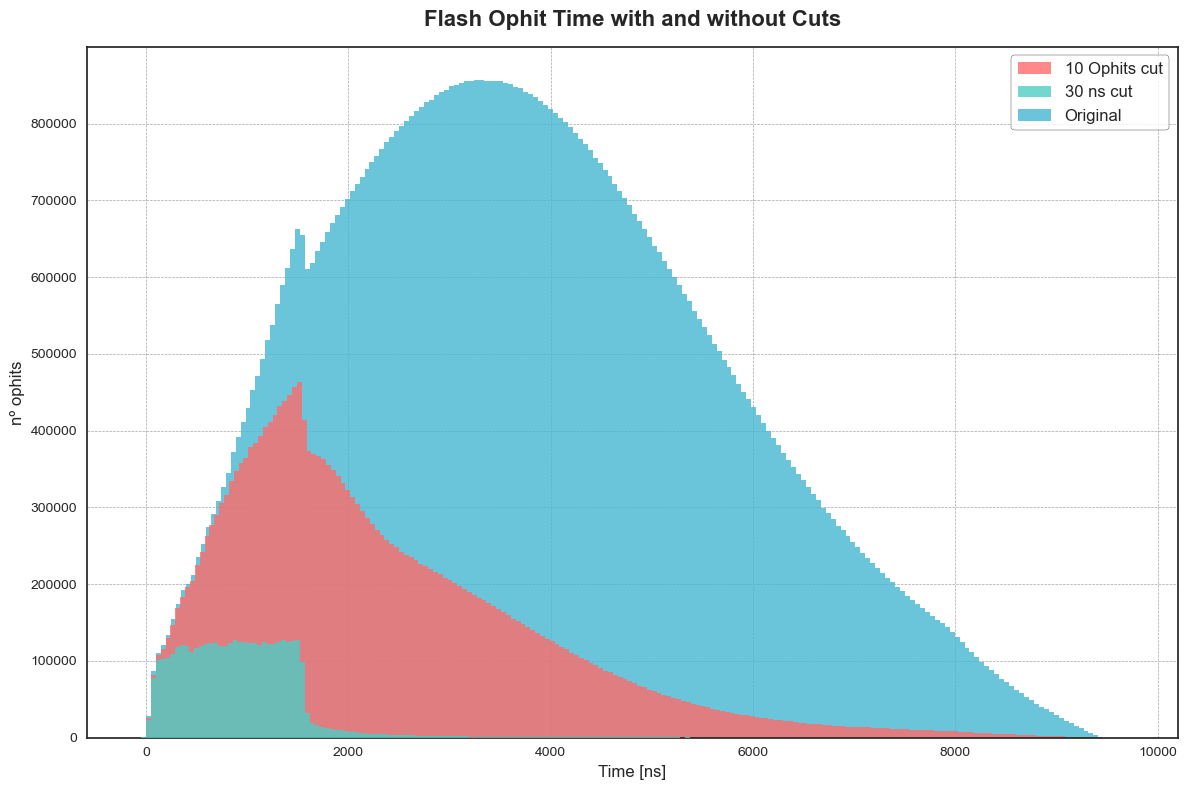

In [48]:
import matplotlib.pyplot as plt
import awkward as ak
import numpy as np

# Flatten and convert the Awkward Arrays to NumPy arrays
selected_ophits_t_flattened_nonzero_np = ak.to_numpy(ak.flatten(selected_ophits_t_flattened_nonzero))
selected_ophits_t_2_flattened_nonzero_np = ak.to_numpy(ak.flatten(selected_ophits_t_2_flattened_nonzero))
f_ophit_t_c_1_flattened_nonzero_np = ak.to_numpy(ak.flatten(f_ophit_t_c_1_flattened_nonzero))

# Create a larger figure with a clean style
plt.style.use('seaborn-white')  # Use 'seaborn-white' for a white background
plt.figure(figsize=(12, 8), facecolor='white')  # Increase figure size for better visibility

# Create the histograms with enhanced styling and zorder to control which is in front
plt.hist(selected_ophits_t_flattened_nonzero_np, bins=200, color='#FF6B6B', alpha=0.8, 
         label='10 Ophits cut', linewidth=0.5, zorder=2)  # Behind
plt.hist(selected_ophits_t_2_flattened_nonzero_np, bins=200, color='#4ECDC4', alpha=0.8, 
         label='30 ns cut', linewidth=0.5, zorder=3)  # Middle
plt.hist(f_ophit_t_c_1_flattened_nonzero_np, bins=200, color='#45B7D1', alpha=0.8, 
         label='Original', linewidth=0.5, zorder=1)  # Front (highest zorder)

# Customize the plot
plt.legend(fontsize=12, loc='upper right', frameon=True, facecolor='white', edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.7, color='gray', linewidth=0.5)
plt.title('Flash Ophit Time with and without Cuts', fontsize=16, pad=15, fontweight='bold')
plt.xlabel('Time [ns]', fontsize=12)
plt.ylabel('nº ophits', fontsize=12)

# Adjust tick labels for readability
plt.tick_params(axis='both', labelsize=10)
plt.rcParams['figure.facecolor'] = 'white'

# Set axes background to white
plt.gca().set_facecolor('white')

# Add some padding to prevent cutoff
plt.tight_layout()

# Show the plot
plt.show()


In [49]:
import numpy as np

# Asumiendo que ya tienes las matrices aplanadas y sin ceros
# Calcula la desviación estándar para ambos casos
std_10ophits_cut = np.std(selected_ophits_t_flattened_nonzero_np)
std_30ns_cut = np.std(selected_ophits_t_2_flattened_nonzero_np)

# Imprime los resultados
print(f"Desviación estándar de 10 Ophits cut: {std_10ophits_cut}")
print(f"Desviación estándar de 30 ns cut: {std_30ns_cut}")


Desviación estándar de 10 Ophits cut: 1546.993038976822
Desviación estándar de 30 ns cut: 630.8669519458499


**check**

In [13]:
print("selected_ophits_t_2:", selected_ophits_t)
print("selected_ophits_PE_2:", selected_ophits_PE)
print("selected_ophits_ch_2:", selected_ophits_ch[0][0])

selected_ophits_t_2: [[[1.52e+03, 1.5e+03, 1.49e+03, ..., 1.5e+03, 1.5e+03, 1.51e+03], ...], ...]
selected_ophits_PE_2: [[[86.3, 103, 268, 1.44e+03, 3.54e+03, ..., 34.8, 50.8, 44.6, 50.2], ...], ...]
selected_ophits_ch_2: [6, 8, 10, 12, 14, 16, 36, 38, 40, ..., 272, 274, 294, 296, 298, 300, 302, 304]


In [99]:
import awkward as ak

# Select the first flash (e.g., the first one)
flash_0 = selected_ophits_ch_2[0][0]

# Create a boolean mask for the condition (value == 70)
mask_70 = flash_0 == 70

# Count how many times 70 appears in the flash by summing the boolean mask
count_70_flash_0 = ak.sum(mask_70)

print(f"Number of 70's in flash 0: {count_70_flash_0}")


Number of 70's in flash 0: 10


In [27]:
n_events = len(selected_ophits_t_c2)

# Create matrices to store the number of photoelectrons and times for each event and channel
pe_matrix = np.zeros((n_events, 312))
time_matrix = np.zeros((n_events, 312))

# Populate the matrices
for i in range(n_events):
    for j in range(len(selected_ophits_t_c2[i])):
        for k, l, t in zip(selected_ophits_PE[i][j], selected_ophits_ch[i][j], selected_ophits_t_c2[i][j]):
            pe_matrix[i][l] += k
            time_matrix[i][l] += k * t  # Weight times by charge

                # Normalize time_matrix using the sum of weights

for i in range(n_events):
    for j in range(312):
        if pe_matrix[i][j] != 0:
            time_matrix[i][j] /= pe_matrix[i][j]
        else:
            time_matrix[i][j] = 0

In [28]:
# Save the matrices to a CSV file
np.savetxt("saved_archives/pe_matrix_&_time_matrix/v0603_timematrix_noTPCselection_c2_10ophits.csv", time_matrix, delimiter=",")

## Plot Flash Time - nuvT and different variables to see they are still alignated

In [7]:
flash_time_c_1 = flash_time_4*1000 - ToF_inside - ToF_outside
flash_time_c_2 = flash_time_4*1000 - ToF_inside - ToF_outside - ak.flatten(nuvT_c)

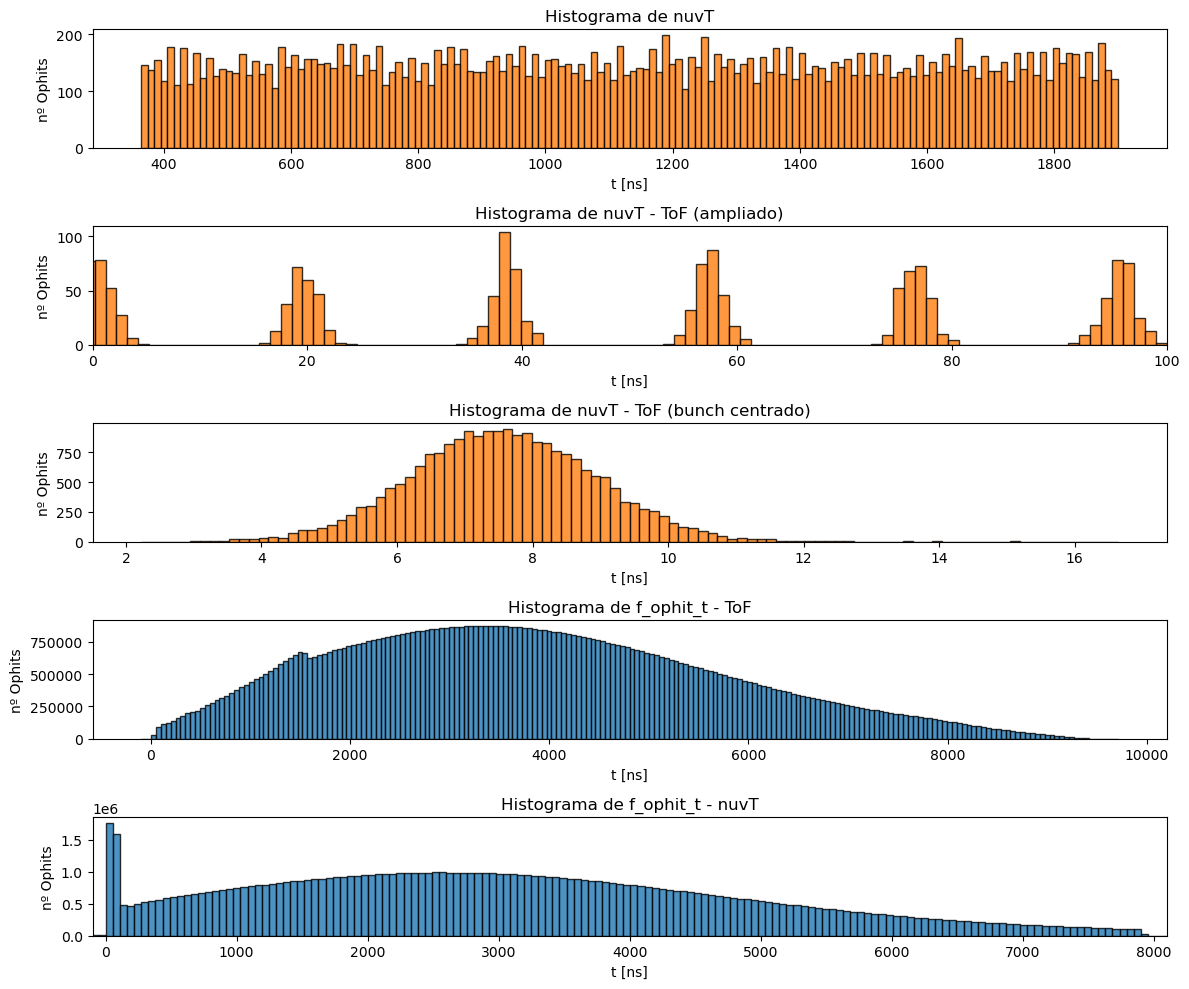

In [17]:
import matplotlib.pyplot as plt


f_ophit_t_c_1_np = ak.flatten(f_ophit_t_c_1, axis=None)
f_ophit_t_c_2_np = ak.flatten(f_ophit_t_c_2, axis=None)

fig, axs = plt.subplots(5, 1, figsize=(12,10))  # Two subplots side by side

# Plot nuvT histogram
axs[0].hist(nuvT_4, bins=150, color='#ff7f0e', edgecolor='black', alpha=0.8)
axs[0].set_xlabel("t [ns]")
axs[0].set_ylabel("nº Ophits")
axs[0].set_title("Histograma de nuvT")

axs[1].hist(nuvT_c, bins=1500, color='#ff7f0e', edgecolor='black', alpha=0.8)
axs[1].set_xlabel("t [ns]")
axs[1].set_ylabel("nº Ophits")
axs[1].set_title("Histograma de nuvT - ToF (ampliado)")
axs[1].set_xlim(0,100)

# Plot nuvT histogram
axs[2].hist(nuvT_c_bunch, bins=100, color='#ff7f0e', edgecolor='black', alpha=0.8)
axs[2].set_xlabel("t [ns]")
axs[2].set_ylabel("nº Ophits")
axs[2].set_title("Histograma de nuvT - ToF (bunch centrado)")

# Plot flash_time histogram
axs[3].hist(f_ophit_t_c_1_np, bins=200, color='#1f77b4', edgecolor='black', alpha=0.8)
axs[3].set_xlabel("t [ns]")
axs[3].set_ylabel("nº Ophits")
axs[3].set_title("Histograma de f_ophit_t - ToF")
axs[4].set_xlim(-100,8100)

# Plot flash_time histogram
axs[4].hist(f_ophit_t_c_2_np, bins=200, color='#1f77b4', edgecolor='black', alpha=0.8)
axs[4].set_xlabel("t [ns]")
axs[4].set_ylabel("nº Ophits")
axs[4].set_title("Histograma de f_ophit_t - nuvT")
axs[4].set_xlim(-100,8100)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


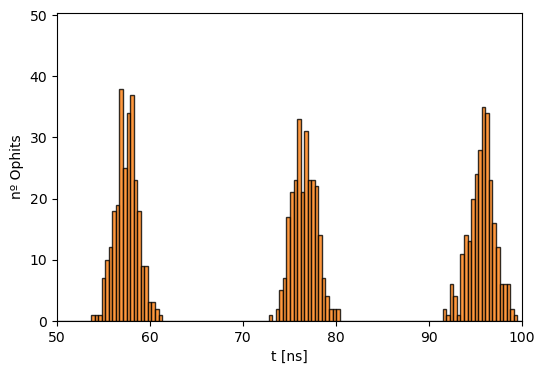

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.hist(nuvT_c, bins=4000, color='#ff7f0e', edgecolor='black', alpha=0.8)
plt.xlabel("t [ns]")
plt.ylabel("nº Ophits")
plt.xlim(50, 100)

plt.show()


In [37]:
nuvT_np = ak.flatten(nuvT_c)
rest1 = flash_time_c_1 - nuvT_np
rest1_np = ak.flatten(rest1, axis=None)

In [38]:
rest2 = f_ophit_t_c_1 - nuvT_np
rest2_np = ak.flatten(rest2, axis=None)

In [49]:
print(rest2)
print(f_ophit_t_c_2)

[[[7.89e+03, 7.87e+03, 7.86e+03, 7.83e+03, ..., 22.3, 16.3, 18.3], ...], ...]
[[[7.89e+03, 7.87e+03, 7.86e+03, 7.83e+03, ..., 22.3, 16.3, 18.3], ...], ...]


In [40]:
print(f_ophit_t_c_1)
print(nuvT_np)

[[[8.31e+03, 8.3e+03, 8.26e+03, 8.23e+03, ..., 385, 403, 389, 391], ...], ...]
[473, 418, 911, 320, 248, 891, 643, ..., 588, 607, 872, 533, 339, 682, 76.9]


In [46]:
# Create masks for PMT (0 and 1) and XAS (2 and 3)
mask_pmt = (categorized_flashes_4 == 0) | (categorized_flashes_4 == 1)
mask_xas = (categorized_flashes_4 == 2) | (categorized_flashes_4 == 3)

# Select values and flatten into a single vector
pmt = ak.flatten(rest2[mask_pmt])
xas = ak.flatten(rest2[mask_xas])

# Output
print("PMT:", pmt)
print("XAS:", xas)

PMT: [[7.89e+03, 7.87e+03, 7.86e+03, 7.83e+03, ..., 18.3, 22.3, 16.3, 18.3], ...]
XAS: [[7.18e+03, 7.1e+03, 6.9e+03, 6.83e+03, ..., 63.3, 47.3, 47.3, 47.3], ...]


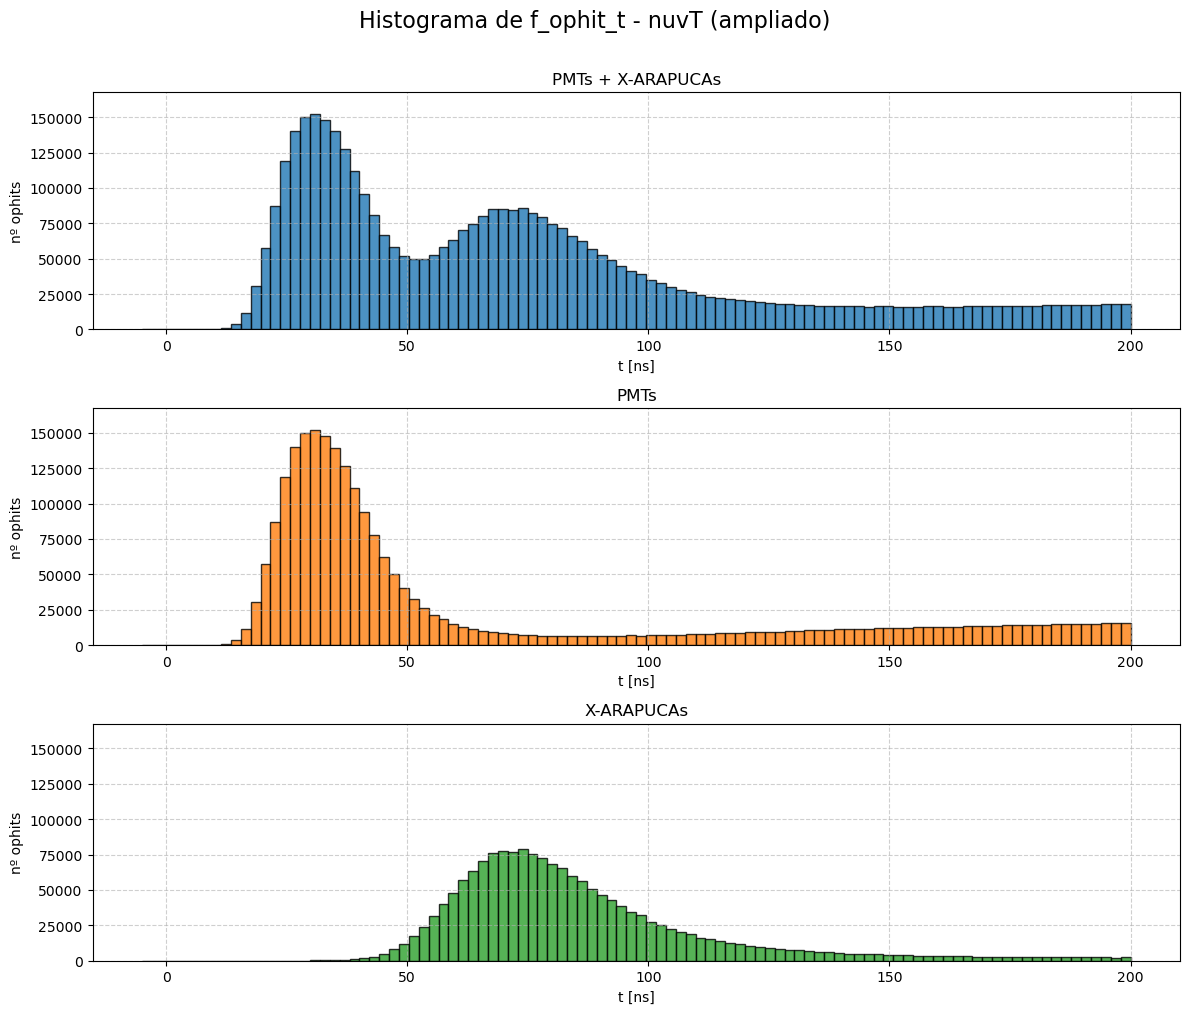

In [67]:
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt

# Ensure conversion to NumPy
rest1_np = ak.to_numpy(rest2_np)
rest1_np_pmt = ak.to_numpy(ak.flatten(pmt))
rest1_np_xas = ak.to_numpy(ak.flatten(xas))

# Define consistent bins
bins = np.linspace(-5, 200, 101)
#bins=np.linspace(0,10000,200)
# Compute max counts for y-limit
y_max = max(
    np.histogram(rest1_np, bins=bins)[0].max(),
    np.histogram(rest1_np_pmt, bins=bins)[0].max(),
    np.histogram(rest1_np_xas, bins=bins)[0].max(),
) * 1.1  # Adding a margin

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 10))

# Histogram of all flash times
axs[0].hist(rest1_np, bins=bins, color='#1f77b4', edgecolor='black', alpha=0.8)
axs[0].set_title("PMTs + X-ARAPUCAs")

# Histogram of PMT flash times
axs[1].hist(rest1_np_pmt, bins=bins, color='#ff7f0e', edgecolor='black', alpha=0.8)
axs[1].set_title("PMTs")

# Histogram of XARAPUCA flash times
axs[2].hist(rest1_np_xas, bins=bins, color='#2ca02c', edgecolor='black', alpha=0.8)
axs[2].set_title("X-ARAPUCAs")

# Apply common limits
for ax in axs:
    #ax.set_xlim(-5, 80)
    ax.set_ylim(0, y_max)
    ax.set_xlabel("t [ns]")
    ax.set_ylabel("nº ophits")
    ax.grid(True, linestyle="--", alpha=0.6)

# Add a title for the whole figure
fig.suptitle("Histograma de f_ophit_t - nuvT (ampliado)", fontsize=16, y=1.01)

plt.tight_layout()
plt.show()


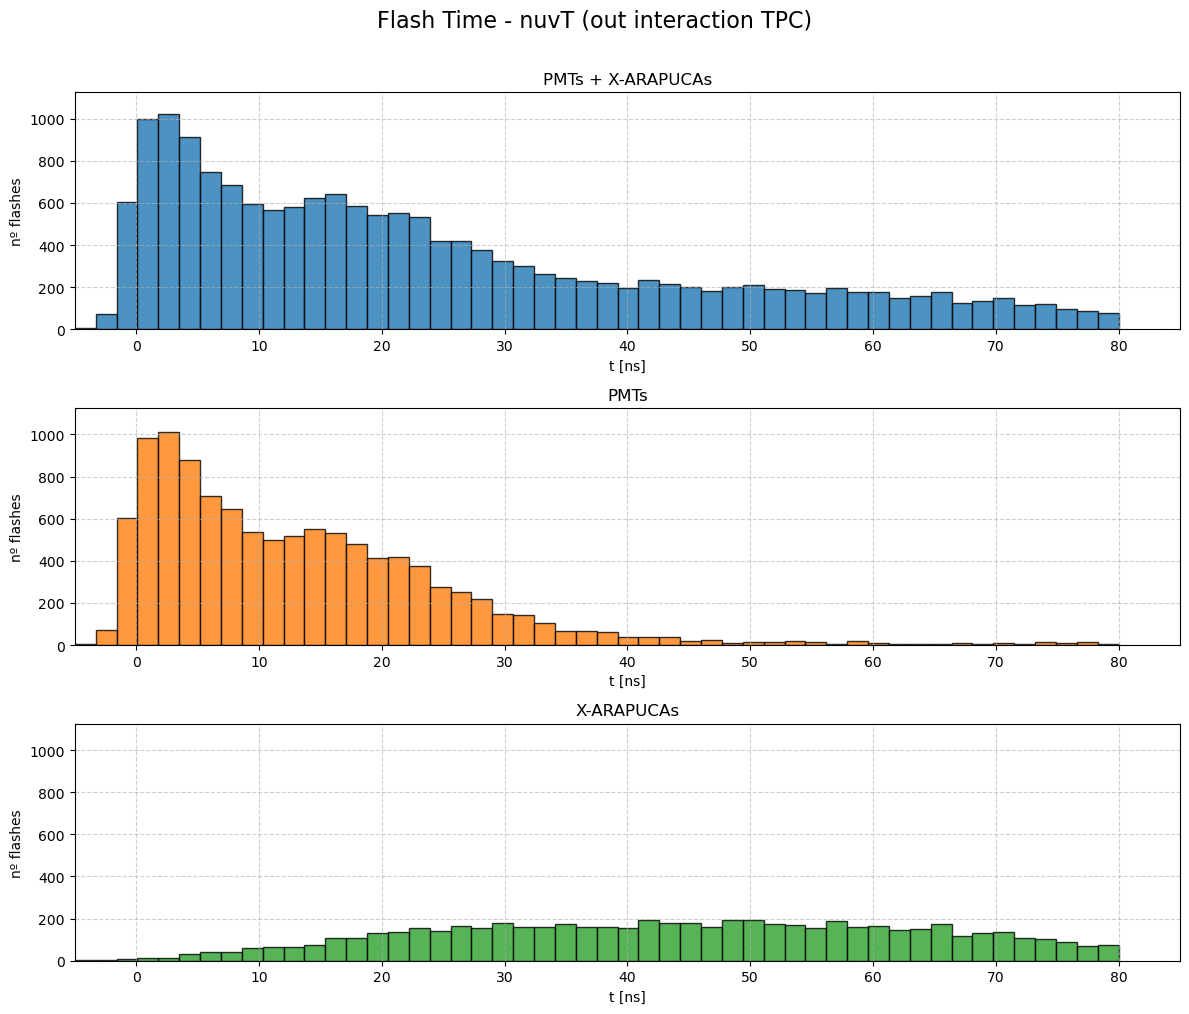

In [ ]:
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt

# Ensure conversion to NumPy
rest1_np = ak.to_numpy(rest1_np_nottpc)
rest1_np_pmt = ak.to_numpy(pmt_nottpc)
rest1_np_xas = ak.to_numpy(xas_nottpc)

# Define consistent bins
bins = np.linspace(-5, 80, 51)

# Compute max counts for y-limit
y_max = max(
    np.histogram(rest1_np, bins=bins)[0].max(),
    np.histogram(rest1_np_pmt, bins=bins)[0].max(),
    np.histogram(rest1_np_xas, bins=bins)[0].max(),
) * 1.1  # Adding a margin

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 10))

# Histogram of all flash times
axs[0].hist(rest1_np, bins=bins, color='#1f77b4', edgecolor='black', alpha=0.8)
axs[0].set_title("PMTs + X-ARAPUCAs")

# Histogram of PMT flash times
axs[1].hist(rest1_np_pmt, bins=bins, color='#ff7f0e', edgecolor='black', alpha=0.8)
axs[1].set_title("PMTs")

# Histogram of XARAPUCA flash times
axs[2].hist(rest1_np_xas, bins=bins, color='#2ca02c', edgecolor='black', alpha=0.8)
axs[2].set_title("X-ARAPUCAs")

# Apply common limits
for ax in axs:
    ax.set_xlim(-5, 85)
    ax.set_ylim(0, y_max)
    ax.set_xlabel("t [ns]")
    ax.set_ylabel("nº flashes")
    ax.grid(True, linestyle="--", alpha=0.6)

# Add a title for the whole figure
fig.suptitle("Flash Time - nuvT (out interaction TPC)", fontsize=16, y=1.01)

plt.tight_layout()
plt.show()


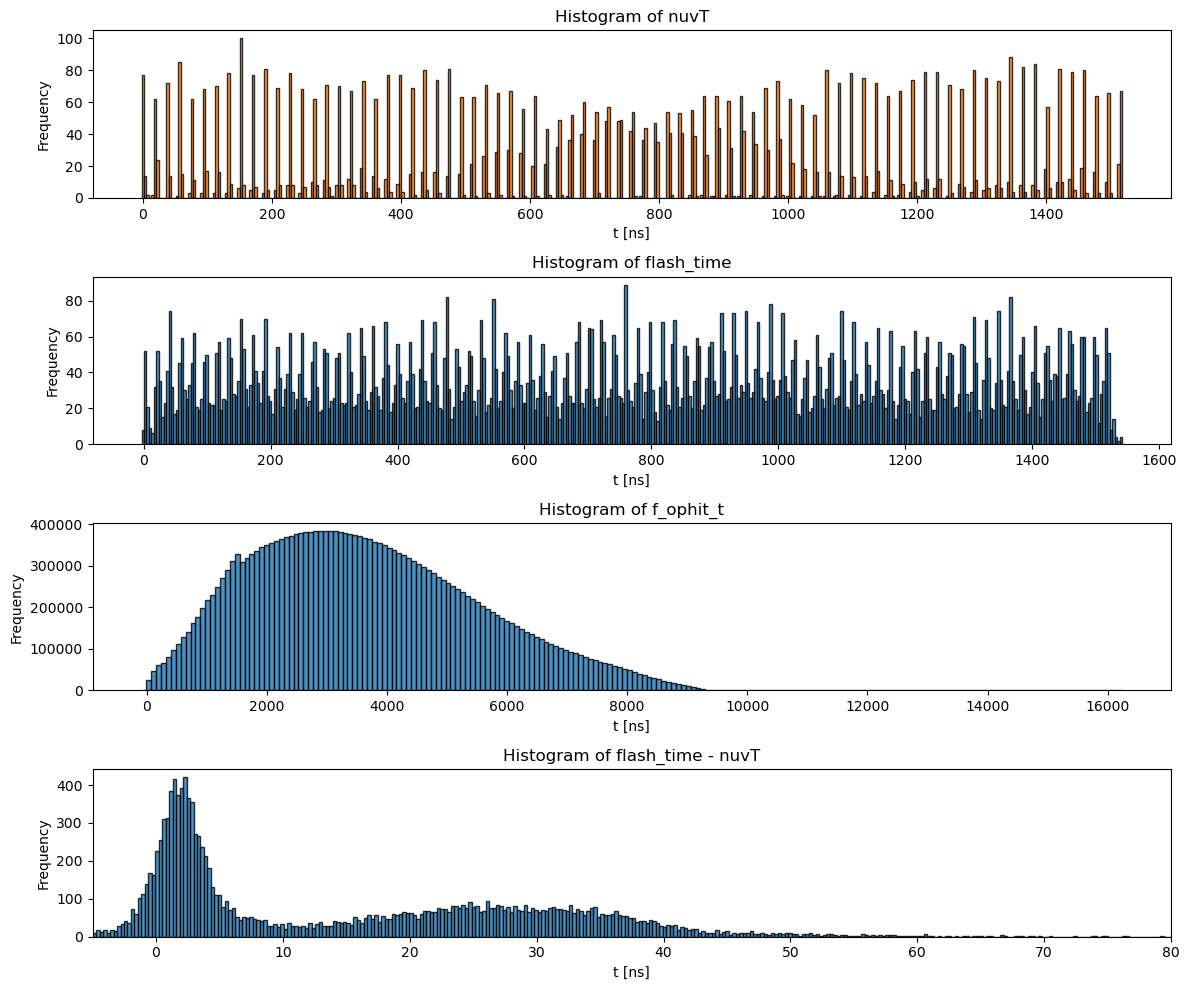

In [68]:
import matplotlib.pyplot as plt

nuvT_np = ak.flatten(nuvT_c)
flash_time_np = ak.flatten(flash_time_c_1)
f_ophit_t_np = ak.flatten(f_ophit_t_c_1, axis=None)
rest1_np = ak.flatten(flash_time_c_1 - nuvT_np, axis=None)

fig, axs = plt.subplots(4, 1, figsize=(12, 10))  # Two subplots side by side

# Plot nuvT histogram
axs[0].hist(nuvT_np, bins=400, color='#ff7f0e', edgecolor='black', alpha=0.8)
axs[0].set_xlabel("t [ns]")
axs[0].set_ylabel("Frequency")
axs[0].set_title("Histogram of nuvT")

# Plot flash_time histogram
axs[1].hist(flash_time_np, bins=400, color='#1f77b4', edgecolor='black', alpha=0.8)
axs[1].set_xlabel("t [ns]")
axs[1].set_ylabel("Frequency")
axs[1].set_title("Histogram of flash_time")

# Plot flash_time histogram
axs[2].hist(f_ophit_t_np, bins=200, color='#1f77b4', edgecolor='black', alpha=0.8)
axs[2].set_xlabel("t [ns]")
axs[2].set_ylabel("Frequency")
axs[2].set_title("Histogram of f_ophit_t")

# Plot flash_time histogram
axs[3].hist(rest1_np, bins=10000, color='#1f77b4', edgecolor='black', alpha=0.8)
axs[3].set_xlabel("t [ns]")
axs[3].set_ylabel("Frequency")
axs[3].set_title("Histogram of flash_time - nuvT")
axs[3].set_xlim(-5,80)


plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [83]:
pe_matrix = np.loadtxt(f"saved_archives/pe_matrix_&_time_matrix/v1202_pematrix_noTPCselection.csv", delimiter=",")

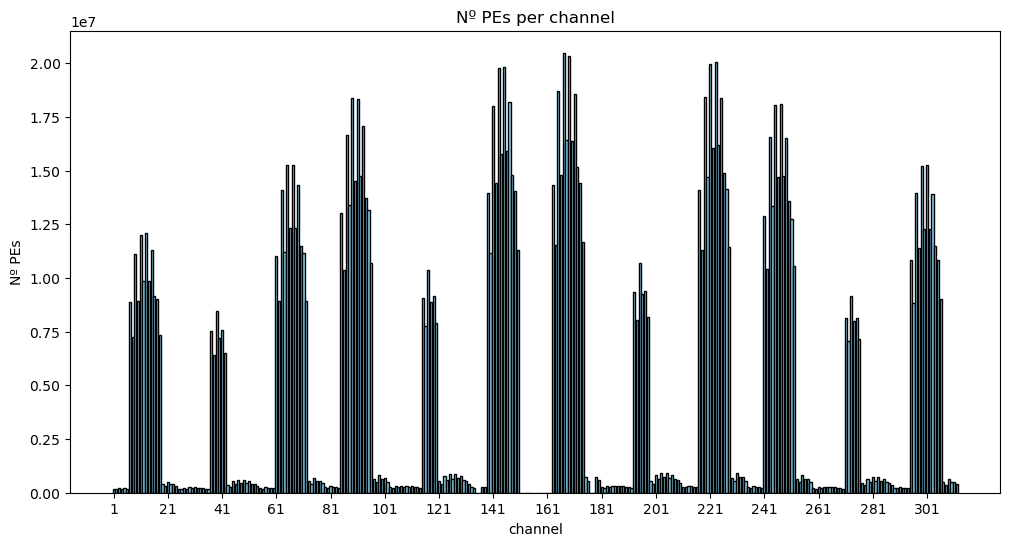

Canales que tienen 0 fotoelectrones: [135 136 151 152 153 154 155 156 157 158 159 160 161 162 177 178]


In [84]:
import numpy as np
import matplotlib.pyplot as plt

# Colapsar la matriz sobre la dimensión de 312 sumando los fotoelectrones por canal
fotoelectrones_por_canal = np.sum(pe_matrix, axis=0)

# Graficar el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(range(1, 313), fotoelectrones_por_canal, color='skyblue', edgecolor='black')
plt.title('Nº PEs per channel')
plt.xlabel('channel')
plt.ylabel('Nº PEs')
plt.xticks(range(1, 313, 20))  # Para mostrar solo algunos números de canal
plt.show()

# Identificar los canales que tienen 0 fotoelectrones
canales_sin_fotoelectrones = np.where(fotoelectrones_por_canal == 0)[0]

# Imprimir los canales que tienen 0 fotoelectrones
print(f"Canales que tienen 0 fotoelectrones: {canales_sin_fotoelectrones + 1}")  # sumamos 1 para hacerlo más intuitivo
